# Direct Grib Read 

If you have installed more recent versions of pygrib, you can ingest grib mosaics directly without conversion to netCDF. This speeds up the ingest by ~15-20 seconds. This notebook will also demonstrate how to use MMM-Py with cartopy, and how to download near-realtime data from NCEP.

In [1]:
%load_ext jupyter_black

In [2]:
import os
import glob
import shutil
from pathlib import Path
from typing import Iterator
from datetime import datetime
from urllib.error import HTTPError


from requests import Session
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import StamenTerrain
import pygrib

import mmmpy
%matplotlib inline
ROOT_DIR = Path(os.path.abspath(__name__)).parents[1]
ROOT_DIR

PosixPath('/workspaces/MMM-Py')

In [3]:
def __iterurls(baseurl: str) -> Iterator[str]:
    (html,) = pd.read_html(baseurl)
    nodes = html["Name"].dropna()
    yield from baseurl + nodes[nodes.str.contains("MergedReflectivityQC")]


def __iterfiles(
    files: pd.Series, input_dt: datetime, max_seconds: int
) -> Iterator[str]:
    time_delta: pd.Series[datetime] = abs(
        input_dt - files.str.extract(r"(\d{8}-\d{6})").astype("datetime64[s]").squeeze()
    )
    yield from files[time_delta.dt.total_seconds() <= max_seconds]


def download_files(
    save_to: Path,
    *,
    input_dt: datetime = datetime.utcnow(),
    max_seconds: int = 300,
) -> None:
    baseurl = "http://mrms.ncep.noaa.gov/data/3DRefl/"
    if not save_to.exists():
        save_to.mkdir()
    with Session() as session:
        for url in __iterurls(baseurl):
            (html,) = pd.read_html(url, skiprows=[1, 2, 3], parse_dates=True)

            for file in __iterfiles(html["Name"].dropna(), input_dt, max_seconds):
                try:
                    r = session.get(url + file, stream=True)
                    r.raise_for_status()
                    with (save_to / file).open("wb") as fileout:
                        shutil.copyfileobj(r.raw, fileout)
                except HTTPError:
                    continue


if __name__ == "__main__":
    download_files(Path("./data"))

In [6]:
import glob
import mmmpy

tile = mmmpy.MosaicTile(
    glob.glob("./data/*")[:2],
    # wgrib2_path=Path("/tmp/mmmpy"),
    # nc_path=Path("/tmp/mmmpy"),
)
tile

mkdir: cannot create directory ‘/Users/tjlang/Downloads/tmpdir/’: No such file or directory
ECCODES ERROR   :  Truncating time: non-zero seconds(38) ignored



********************
diag():
Printing basic metadata and making a simple plot
Data are from MRMS_MergedReflectivityQC_13.00_20220816-005238.grib2.gz
Min, Max Latitude = 20.005000000002696 54.995
Min, Max Longitude = -129.995 -60.00500000006366
Heights (km) = [ 8.5 13. ]
Grid shape = (2, 3500, 7000)
Now plotting ...
Done!
********************



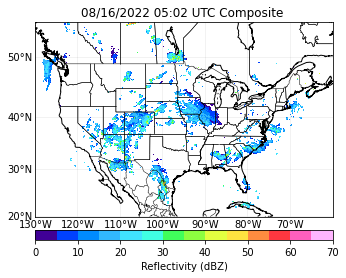

In [8]:
tile.diag()

In [9]:
tile.Duration,tile

120.0

### Direct ingest of grib into MMM-Py

### Plot with cartopy